In [1]:
import os
from time import sleep
from warnings import simplefilter, warn
simplefilter('always', UserWarning)

import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

from tifffile import imread as tifread
from czifile import imread as cziread
from nd2 import imread as nd2read

In [2]:
target_file = r'S:\DBIO_WongGroup_1\Zimeng\_MATE\TEST_FOLDER\prescan.czi'

In [3]:
if target_file.endswith('.tif'):
    raw = tifread(target_file)

if target_file.endswith('.czi'):
    raw = cziread(target_file)
    raw = np.squeeze(raw)          

if target_file.endswith('.nd2'):
    raw = nd2read(target_file)
    raw = np.squeeze(raw) 

raw.shape

(20, 200, 512)

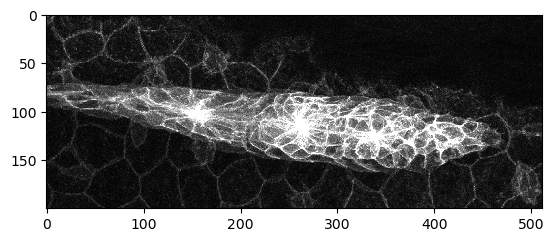

In [4]:
##convert to 8bit
if raw.dtype != np.uint8:
        raw = ( (raw.astype(np.float) - raw.min()) / (raw.max() - raw.min()) * 255 ).astype(np.uint8)

if raw.ndim == 3:
    plt.imshow(np.max(raw,axis=0),interpolation="none",cmap="gray")
    plt.show()
elif raw.ndim == 2:
    plt.imshow(raw,interpolation="none",cmap="gray")
    plt.show()

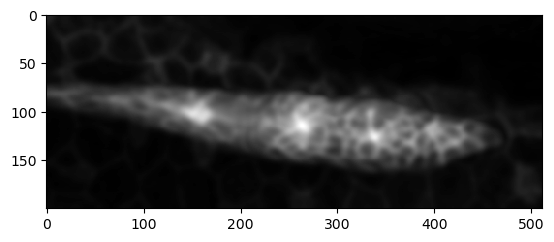

In [5]:
#gaussian filter
raw = ndi.gaussian_filter(raw,3) #PARAM sigma
plt.imshow(np.max(raw,axis=0),interpolation="none",cmap="gray")
plt.show()

In [6]:
##thresholding
thresh_div = 2.0    # XXX: Robustness?  # Param!
thresholds = np.arange(0,256,1)
counts = np.zeros_like(thresholds)

for index,threshold in enumerate(thresholds):

    # Apply current threshold and count objects
    counts[index] = ndi.label(raw>=threshold)[1]
    
counts_smooth = ndi.gaussian_filter1d(counts,3)


22
8


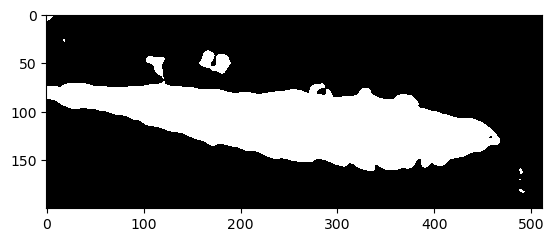

In [7]:
for threshold in thresholds[1:255]:

        # Criterion 1: Is there a threshold before the current one that has more objects?
    if np.max(counts_smooth[:threshold]) > counts_smooth[threshold]:

            # Criterion 2a: Is the current value below the maximum value divided by thresh_div?
        if counts_smooth[threshold] <= (np.max(counts_smooth[:threshold]) / thresh_div):
            break

            # Criterion 2b: Alternatively, if the threshold is followed by an
            #               increase in counts again (i.e. it is a local min.)
            # XXX: If there ever is an "early dip" despite smoothing, this will
            #      lead to a low threshold being accepted!
        elif counts_smooth[threshold+1] > counts_smooth[threshold]:
            break

    # Fallback: If the detected threshold has 0 objects, take the next one
    #           before that had some objects. Note that this is important since
    #           the smoothing will often stretch the curve out too far, leading
    #           to thresholds that yield no objects when applied to the image!
if counts[threshold] == 0:
    for backstep in range(1,threshold):
        if counts[threshold-backstep] > 0:
            threshold = threshold-backstep
            break

# Terminal fallback: If the final result is still nonesense, give up
if threshold >= 250 or threshold == 0 or counts[threshold] == 0:
    raise Exception("THRESHOLD DETECTION FAILED! Image analysis run aborted...")

print(threshold)
print(counts[threshold])

mask = raw >= threshold

plt.imshow(np.max(mask,axis=0),interpolation="none",cmap="gray")
plt.show()

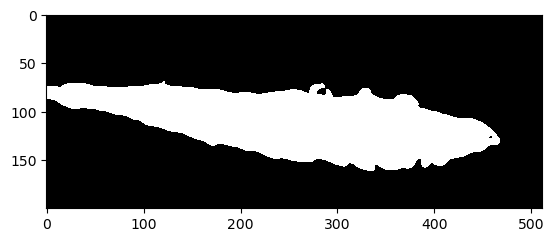

In [8]:
img_bin_labeled = ndi.label(mask)[0]
obj_nums,obj_sizes = np.unique(img_bin_labeled,return_counts=True)
largest_obj = np.argmax(obj_sizes[1:])+1
mask[img_bin_labeled!=largest_obj] = 0

plt.imshow(np.max(mask,axis=0),interpolation="none",cmap="gray")
plt.imsave('mask.png', np.max(mask,axis=0), cmap="gray")
plt.show()


In [9]:
cen = ndi.center_of_mass(mask) ###measurements is deprecated so changed to ndi.center_of_mass

# Get positions for 3D
if raw.ndim == 3:

    # Use centroid positions as focusing targets
    z_pos = cen[0]
    y_pos = cen[1]

    # z limit: An absolute limitation on how much it can move!
    z_limit = 1.0 / 10.0     # Fraction of image size
    z_limit_top = (raw.shape[0]-1)/2.0 + z_limit * (raw.shape[0]-1)
    z_limit_bot = (raw.shape[0]-1)/2.0 - z_limit * (raw.shape[0]-1)
    if z_pos > z_limit_top:
        warn("z_pos > z_limit_top; using z_limit_top!")
        z_pos = z_limit_top
    if z_pos < z_limit_bot:
        warn("z_pos < z_limit_bot; using z_limit_bot!")
        z_pos = z_limit_bot

    # Invert resulting z_position for scope frame of reference
    z_pos = (raw.shape[0]-1) - z_pos  # Inversion for scope frame of ref

In [11]:
# Collapse to x axis
if raw.ndim == 3:
    collapsed = np.max(np.max(mask,axis=0),axis=0)
else:
    collapsed = np.max(mask,axis=0)

# Find frontal-most non-zero pixel
front_pos = np.max(np.nonzero(collapsed)[0])

if front_pos < collapsed.shape[0] / 2.0:

    # In this case, the mask probably missed a lot at the tip...
    warn("The detected front_pos is too far back, likely due to a masking error. Moving default distance.")

    # Handle it...
    default_step_fract = 1.0/8.0
    x_pos = 1.0/2.0 * collapsed.shape[0] + default_step_fract * collapsed.shape[0]

# If the tip of the mask touches the front end of the image
elif front_pos == collapsed.shape[0] - 1:

    # In this case, the prim has probably moved out of the frame
    warn("The prim has probably moved out of the frame. Moving default catch-up distance.")

    # Handle it...
    default_catchup_fract = 1.0/5.0
    x_pos = 1.0/2.0 * collapsed.shape[0] + default_catchup_fract * collapsed.shape[0]

blank_fract = 1.0/5.0
x_pos = front_pos + blank_fract * collapsed.shape[0] - 1.0/2.0 * collapsed.shape[0]



In [15]:
print('z_pos:', z_pos, 'y_pos:', y_pos, 'x_pos:', x_pos)

z_pos: 9.232831163696947 y_pos: 112.23669979950866 x_pos: 314.4
